# Exercises day 01

In [179]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import collections

### Testing Neumanns simple method

In [180]:
def neumann_four_digit(seed : int, break_point : int = None) -> tuple[list[float], list[int], list[int]]:
    """
        A function that generates a sequence of random numbers using the Neumann four digit method.
        
        :param seed: The seed for the Neumann generator.
        :param break_point: The number of iterations to run the generator for.
        
        :return: A tuple containing the sequence of random numbers, the sequence of x values, and the sequence of x^2 values.
    """
    
    if break_point is None:
        break_point = 10**6 # 1 million
    
    assert type(break_point) is int, "break_point must be an integer!"
    
    U = []
    xs = []
    xsquareds = []
    x = seed
    counter = 0
    while counter < break_point and x > 0:
        U.append(x / 10**4)
        xs.append(x)
        xsquareds.append(x ** 2)
        x = ((x ** 2) // 10**2) % 10**4
        counter += 1
    
    return U, xs, xsquareds

U, xs, xsquareds = neumann_four_digit(7182, 30)

print(f"U = \n{U}\n")
print(f"xs = \n{xs}\n")
print(f"xsquareds = \n{xsquareds}\n")

U = 
[0.7182, 0.5811, 0.7677, 0.9363, 0.6657, 0.3156, 0.9603, 0.2176, 0.7349, 0.0078, 0.006, 0.0036, 0.0012, 0.0001]

xs = 
[7182, 5811, 7677, 9363, 6657, 3156, 9603, 2176, 7349, 78, 60, 36, 12, 1]

xsquareds = 
[51581124, 33767721, 58936329, 87665769, 44315649, 9960336, 92217609, 4734976, 54007801, 6084, 3600, 1296, 144, 1]



## Ex. 1

Implement a Linear Congruental Generator

In [181]:
def linear_congruental_generator(multiplier : int, shift : int, modulus: int, x0 : int = None, break_point : int = None) -> tuple[list[int], list[float]]:
    """
        Generates a list of random numbers using the linear congruental generator method.
        
        NOTE: random_nums and U will have length 'modulus' if the parameters follows the conditions
        of Theorem 1 Maximum Cycle Length.

        :param multiplier: The multiplier (a) used in the formula.
        :param shift: The shift (c) used in the formula.
        :param modulus: The modulus (M) used in the formula.
        :param x0: initial value (x0) used in the formula. If not provided, a random value will be used.
        
        :return random_nums: a list of randomly generated numbers.
        :return U: a list of random numbers between 0 and 1.
    """
    
    assert type(modulus) is int, "Modulus must be an integer."
    assert modulus > 0, "Modulus must be greater than 0."
    
    if x0 is None:
        x0 = np.random.randint(0, modulus)
    
    if break_point is None:
        break_point = modulus
        
    random_nums = [x0]
    U = [x0 / modulus]
    random_nums_generated = 0
    while random_nums_generated < modulus and random_nums_generated < break_point:
        random_nums.append((multiplier * random_nums[-1] + shift) % modulus) 
        U.append(random_nums[-1] / modulus)
        random_nums_generated += 1
    
    return random_nums, U


Testing whether the Linear Congruental Generator works as presented in the slides

In [182]:
M = 16
a = 5
c = 1
x0 = 3

ranom_nums, U = linear_congruental_generator(multiplier=a, shift=c, modulus=M, x0=x0)

print(f"Random numbers: \n{ranom_nums}\n")
print(f"U: \n{U}\n")

Random numbers: 
[3, 0, 1, 6, 15, 12, 13, 2, 11, 8, 9, 14, 7, 4, 5, 10, 3]

U: 
[0.1875, 0.0, 0.0625, 0.375, 0.9375, 0.75, 0.8125, 0.125, 0.6875, 0.5, 0.5625, 0.875, 0.4375, 0.25, 0.3125, 0.625, 0.1875]



### Histogram

In [183]:
def plot_hist_and_corr(multiplier : int, shift : int, modulus: int, x0 : int = None, num_bins : int = None, num_scatter_points : int = None) -> None:
    """
        This function plots the histogram and corresponding correlation plot of a specific run of our LCG.
        
        :param multiplier: The multiplier (a) used in the formula.
        :param shift: The shift (c) used in the formula.
        :param modulus: The modulus (M) used in the formula.
        :param x0: initial value (x0) used in the formula. If not provided, a random value will be used.
        :param num_bins: number of bins in the histogram.
        :param num_scatter_points: number of points plotted in the correlation plot.
        
        :return: returns void.
    """
    if num_bins is None:
        num_bins = 10
    if x0 is None:
        # This is dumb, but we roll
        x0 = np.random.randint(0, modulus)
    if num_scatter_points is None:
        num_scatter_points = 100
        
    random_nums_hist, U_hist = linear_congruental_generator(multiplier=multiplier, shift=shift, modulus=modulus, x0=x0)
    
    # counts, bins = np.histogram(U_hist, bins=num_bins)
    plt.figure(figsize=(16, 9))
    plt.subplot(1,2,1)
    plt.title(f"Histogram of random numbers, with: \nM: {modulus}, a: {multiplier}, c: {shift}, x0: {x0}")
    plt.hist(U_hist, bins=num_bins)
    
    plt.subplot(1, 2, 2)
    plt.title("Correlation plot of $U_{i - 1}$ and $U_i$")
    plt.scatter(U_hist[:num_scatter_points], U_hist[1:(num_scatter_points + 1)], s=[0.1]*num_scatter_points)
    
    plt.show()
    

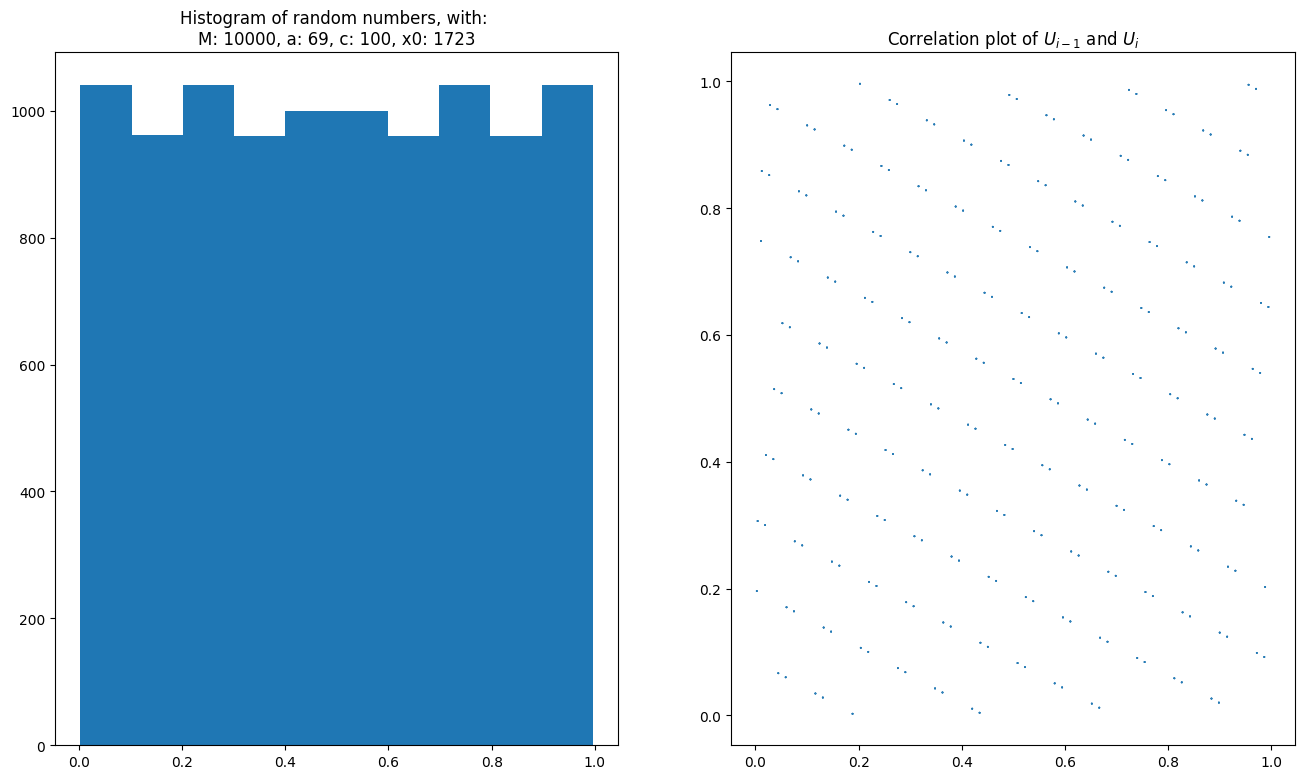

In [184]:
M_hist = 10**4
multiplier_hist = 69
shift_hist = 100
x0_hist = 420

plot_hist_and_corr(multiplier = multiplier_hist, shift =shift_hist, modulus = M_hist, x0 = None, num_bins = None, num_scatter_points = 1000)


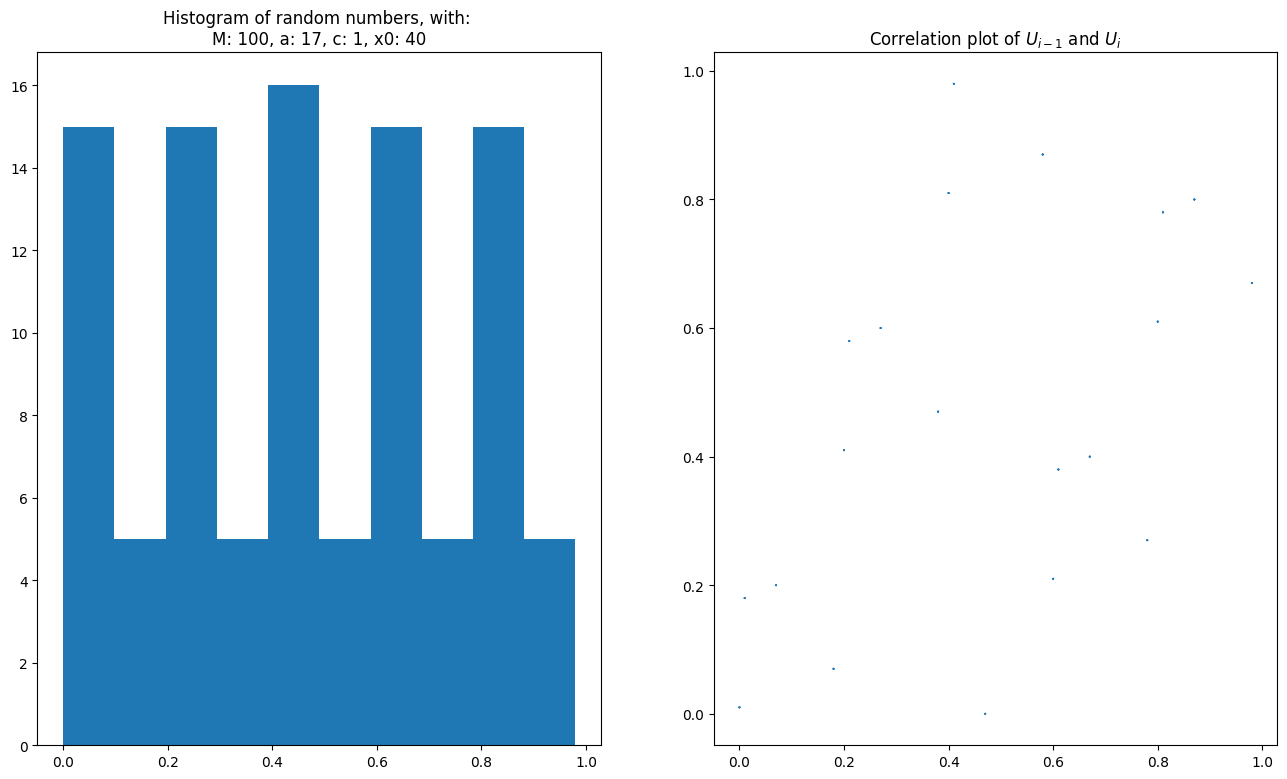

In [185]:
M_hist = 100
multiplier_hist = 17
shift_hist = 1
x0_hist = 69

plot_hist_and_corr(multiplier = multiplier_hist, shift =shift_hist, modulus = M_hist, x0 = None, num_bins = None, num_scatter_points = None)

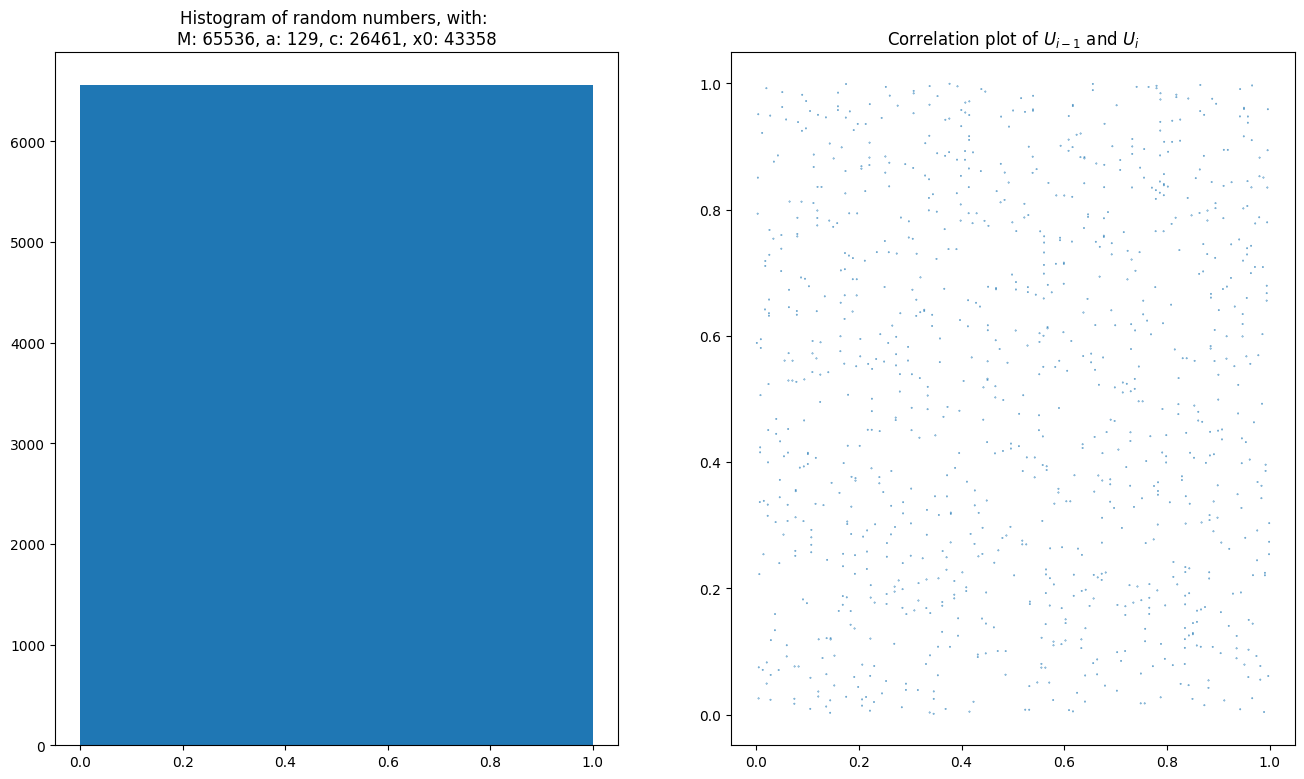

In [186]:
M_hist = 65536
multiplier_hist = 129
shift_hist = 26461
x0_hist = 420

plot_hist_and_corr(multiplier = multiplier_hist, shift =shift_hist, modulus = M_hist, x0 = None, num_bins = None, num_scatter_points = 1000)

### Test
The $\chi$-test

In [187]:
def chi_squared_test_U(U : list[float], num_bins : int) -> float:
    """
        This function performs the chi-squared test on a list of random numbers.
        For uniform expected distribution.
        
        :param U: list of random numbers (uniformly distributed).
        :param num_bins: number of bins to divide the random numbers into.
        
        :return p: returns the p-value of the test.
    """
    
    N = len(U)
    expected_num_in_bins = N / num_bins
    
    # Divied into bins
    counts, _ = np.histogram(U, bins=num_bins)

    T = np.abs(np.sum((counts - expected_num_in_bins)**2 / expected_num_in_bins))

    df = num_bins -1 -1 # when number of estimated parameters is m=1
    
    p = 1 - scipy.stats.chi2.cdf(T, df)
    
    return p

In [188]:
M = 65536
multiplier = 129
shift = 26461
x0 = 420

_, U = linear_congruental_generator(multiplier=multiplier, shift=shift, modulus=M, x0=x0)

bins1 = 10
bins2 = 20
print(f"Chi-squared test for {bins1} bins:")
print(f"Chi-squared test give p-value of: {chi_squared_test_U(U, bins1)}\n")

print(f"Chi-squared test for {bins2} bins:")
print(f"Chi-squared test give p-value of: {chi_squared_test_U(U, bins2)}")

Chi-squared test for 10 bins:
Chi-squared test give p-value of: 0.9999999999999996

Chi-squared test for 20 bins:
Chi-squared test give p-value of: 1.0


Kolmogorov Smirnov

In [189]:
def Kolmogorov_Smirnov(U):
    # For uniform expected distribution: F(x) = x

    U_sort = np.sort(U)
    n = len(U)

    D = []
    #F,Fn = [],[]
  
    for i, x ,in enumerate(U_sort):
        #F.append((i+1)/n)
        #Fn.append(np.sum(U_sort<=x)/n)
        F = (i+1)/n
        print(np.sum(U_sort<=x))
        Fn = np.sum(U<=x)/n
        D.append(np.abs(Fn -F))

    D_n = np.max(D)
    #print(Fn)
    #plt.figure()
    #plt.plot(F, label='F',)
    #plt.plot(Fn, label='Fn')
    #plt.legend()
    #plt.show()
    #print(D_n)
    print(f"Kolmogorov Smirnov: {1-scipy.special.kolmogorov(D_n)}")
    



In [190]:
#M = 65536
#a = 129
#c = 26461
#x0 =420
M = 16
a = 5
c = 1
x0 = 3
#M = 10**4
#a = 69
#c = 100
#x0 = 420


ranom_nums, U = linear_congruental_generator(multiplier=a, shift=c, modulus=M, x0=x0)
print(np.sort(U))
#Kolmogorov_Smirnov(U)

[0.     0.0625 0.125  0.1875 0.1875 0.25   0.3125 0.375  0.4375 0.5
 0.5625 0.625  0.6875 0.75   0.8125 0.875  0.9375]


### Run-tests

#### Up-and-Down test

In [191]:
def up_and_down_test(random_nums : list[float]):
    """
        The up and down test is a test for randomness. It counts the number of runs in a sequence of random numbers.
        A run is defined as a sequence of consecutive numbers that are either increasing or decreasing.
        (See slide 20 on 'slide2bm1.pdf' for more info).
        
        :param random_nums: a list of random numbers.
        
        :return Z: the test statistic (I think).
    """
    R = []
    
    n = len(random_nums)
    
    previous = None
    run_length = 0
    for i in range(len(random_nums) - 1):
        if random_nums[i] < random_nums[i + 1]:
            if previous == "up" or previous is None:
                run_length += 1
                previous = "up"
            elif previous == "down":
                R.append(run_length)
                run_length = 1
                previous = "up"
        else:
            if previous == "down" or previous is None:
                run_length += 1
                previous = "down"
            elif previous == "up":
                R.append(run_length)
                run_length = 1
                previous = "down"
                
    count = collections.Counter(R)
    
    for key, val in count.items():
        expected_val = 0
        if key == 1:
            expected_val = (n + 1)/ 12
        elif key == 2:
            expected_val = (11*n -4) / 12
        else:
            expected_val = (2 * ((key**2 + 3*key + 1)*n - (key**3 + 3*key**2 - key - 4)) ) / np.math.factorial(key + 3)
        
        print(f"Expected number of runs of length: {key} is: {np.round(expected_val, 2):>10}")
        print(f"The actual length is: {np.round(val, 2):>26}.00\n") # <-- this is some scummy code and won't exrapolate to all cases.
    
    X = len(R)
    Z = (X - (2 * n - 1) / 3) / np.sqrt( ((16 * n - 29) / 90) ) 
    
    return Z
    

#### Above/Below


In [192]:
def above_below(random_nums : list[float], median : float) -> tuple[list[int], list[int], int, int, float, float]:
    """
        Calculates the runs for the Above/Below test, as given in the first lecture.
        (See slide 17, on 'slide2bm1.pdf').
        NOTE: This is made for for a sample of uniformly distributed random numbers.
        (So this distribution should have a theoretical median).
        NOTE: The test statistic for this test is given as R_a + R_b.
        
        :param random_nums: a list of random numbers.
        :param median: the expected median of the random numbers.
        
        :return R_a: a list of runs of numbers above the median.
        :return R_b: a list of runs of numbers below the median.
        :return n_1: the total number of numbers above the median.
        :return n_2: the total number of numbers below the median.
        :return mu: the expected value of the test statistic.
        :return sigma: the standard deviation of the test statistic.
    """
    
    R_a = []
    R_b = []
    
    previous = None
    run_length = 0
    for random_num in random_nums:
        if random_num < median:
            if previous == "below" or previous is None:
                run_length += 1
                previous = "below"
            elif previous == "above":
                R_b.append(run_length)
                run_length = 1
                previous = "below"
        elif random_num > median:
            if previous == "above" or previous is None:
                run_length += 1
                previous = "above"
            elif previous == "below":
                R_a.append(run_length)
                run_length = 1
                previous = "above"
    
    n_1 = sum(R_a)
    n_2 = sum(R_b)
    
    mu = 2 * (n_1 * n_2) / (n_1 + n_2) + 1
    sigma = 2 * (n_1 * n_2 * (2 * n_1 * n_2 - n_1 - n_2)) / ((n_1 + n_2)**2 + (n_1 + n_2 - 1))
    
    return R_a, R_b, n_1, n_2, mu, sigma
              

#### Up/Down

In [193]:
def up_down(random_nums : list[float]) -> float:
    """
        Knuth's Up/Down test, as given in the first lecture.
        (See slide 18, on 'slide2bm1.pdf').
        
        :param random_nums: a list of random numbers between 0 and 1.
        
        :return Z: a list (of something I don't know yet).
    """

    n = len(random_nums)
    
    # This is a little confusing and maybe not the best code. We index R, such that index
    # 0 corresponds to a run of length 1, index 1 corresponds to a run of length 2, etc.
    R = np.zeros(6)
    run_length = 1
    for i in range(len(random_nums) - 1):
        if random_nums[i] < random_nums[i + 1]:
            run_length += 1
        else:
            if run_length < 6 and run_length > 0:
                R[run_length - 1] += 1
            elif run_length >= 6:
                R[5] += 1
            else:
                raise ValueError("Run length is less than 1.")
            run_length = 1
    
    R = R.reshape(-1, 1) # <-- importent because otherwise (R - n * B) gives a matrix (and we don't want that, no, no).
    
    A = np.array([
        [4529.4, 9044.9, 13568, 18091, 22615, 27892],
        [9044.9, 18097, 27139, 36187, 45234, 55789],
        [13568, 27139, 40721, 54281, 67852, 83685],
        [18091, 36187, 54281, 72414, 90470, 111580],
        [22615, 45234, 67852, 90470, 113262, 139476],
        [27892, 55789, 83685, 111580, 139476, 172860]
        ])

    B = np.array([
        [1/6],
        [5/24],
        [11/120],
        [19/720],
        [29/5040],
        [1/840]
        ])
    
    Z = (1 / (n - 6)) * (R - n * B).T @ A @ (R - n * B)
    
    return Z.item()



#### Actually running the tests

In [194]:
M = 65536
multiplier = 129
shift = 26461
x0 = 35635

random_nums, U = linear_congruental_generator(multiplier=multiplier, shift=shift, modulus=M, x0=x0)

Z_up_and_down = up_and_down_test(U)
R_a, R_b, n_1, n_2, mu, sigma = above_below(U, 0.5)
T_above_below = len(R_a) + len(R_b)
Z_Up_Down = up_down(U)

print(f"The Z from the up-and-down test: {Z_up_and_down}. \nShould be asymptotically N(0, 1)\n")
print(f"The T from the above_below test: {T_above_below}.\n")
print(f"The Z from the up-down test: {Z_Up_Down}. \nShould be compared with a chi^2(6) dsitribution.")


Expected number of runs of length: 2 is:   60075.25
The actual length is:                      11860.00

Expected number of runs of length: 1 is:     5461.5
The actual length is:                      27326.00

Expected number of runs of length: 3 is:    3458.77
The actual length is:                       3843.00

Expected number of runs of length: 4 is:     754.15
The actual length is:                        671.00

Expected number of runs of length: 5 is:     133.28
The actual length is:                         55.00

The Z from the up-and-down test: 0.5929307368012613. 
Should be asymptotically N(0, 1)

The T from the above_below test: 32922.

The Z from the up-down test: 207.790568063366. 
Should be compared with a chi^2(6) dsitribution.


### Full test

Making a function for making a full test, both with runs and Chi^2

In [197]:
def chungus_test(multiplier : int,
                 shift : int,
                 modulus: int,
                 x0 : int = None,
                 break_point : int = None,
                 significance_level : float = 0.05,
                 expected_median : float = 0.5,
                 plot : bool = False,
                 num_bins : int = None,
                 num_scatter_points : int = None,
                 ) -> None:
    """

    """
    _, U = linear_congruental_generator(multiplier=multiplier, shift=shift, modulus=modulus, x0=x0, break_point=break_point)
    
    print(f"{len(U)} random numbers generated using the Linear Congruental Generator with parameters:")
    print(f"Multiplier (a): {multiplier}")
    print(f"shift (c): {shift}")
    print(f"modulus (M): {modulus}")
    print(f"Initial value (x0): {x0}")
    print(f"\nMultiple tests were performed: \n")
    
    print(f"From the Up-and-Down test we find: ")
    Z_up_and_down = up_and_down_test(U)
    p_up_and_down = 2 * (1 - scipy.stats.norm.cdf(abs(Z_up_and_down), loc = 0, scale = 1))
    
    print(f"This test statistic Z = {Z_up_and_down} \nshould be asymptotically N(0, 1).")
    print(f"We test that by p-value. The p-value is: {p_up_and_down}.")
    print(f"With a significance level of: {significance_level} we find that the test is {'not ' if p_up_and_down < significance_level else ''}significant.\n\n")
    
    print(f"From the Above/ Below test we find: ")
    R_a, R_b, n_1, n_2, mu, sigma = above_below(U, expected_median) # <-- n_1 and n_2 are the number of observations above and below the expected median (here unused).
    T_above_below = len(R_a) + len(R_b)
    p_above_below = 2 * (1 - scipy.stats.norm.cdf(abs(T_above_below), loc = mu, scale = sigma))
    
    print(f"This test statistic T = {T_above_below} \nshould be asymptotically N({round(mu, 2)}, {round(sigma, 2)}).")
    print(f"We test that by p-value. The p-value is: {p_above_below}.")
    print(f"With a significance level of: {significance_level} we find that the test is {'not ' if p_above_below < significance_level else ''}significant.\n\n")
    
    print(f"From the Up/ Down test we find: ")
    Z_up_down = up_down(U)
    p_up_down = 1 - scipy.stats.chi2.cdf(x = Z_up_down, df = 6)
    print(f"The Z from the up-down test: {Z_Up_Down}. \nShould be compared with a chi^2(6) dsitribution.")
    print(f"We test that by p-value. The p-value is: {p_up_down}.")
    print(f"With a significance level of: {significance_level} we find that the test is {'not ' if p_up_down < significance_level else ''}significant.\n\n")
    
    if plot:
        print(f"\nFinally a histogram and correlation plot is given here: \n")
        plot_hist_and_corr(multiplier = multiplier_hist, shift =shift_hist, modulus = M_hist, x0 = x0, num_bins = num_bins, num_scatter_points = num_scatter_points)
    

65537 random numbers generated using the Linear Congruental Generator with parameters:
Multiplier (a): 129
shift (c): 26461
modulus (M): 65536
Initial value (x0): 35635

Multiple tests were performed: 

From the Up-and-Down test we find: 
Expected number of runs of length: 2 is:   60075.25
The actual length is:                      11860.00

Expected number of runs of length: 1 is:     5461.5
The actual length is:                      27326.00

Expected number of runs of length: 3 is:    3458.77
The actual length is:                       3843.00

Expected number of runs of length: 4 is:     754.15
The actual length is:                        671.00

Expected number of runs of length: 5 is:     133.28
The actual length is:                         55.00

This test statistic Z = 0.5929307368012613 
should be asymptotically N(0, 1).
We test that by p-value. The p-value is: 0.5532275067567163.
With a significance level of: 0.05 we find that the test is significant.


From the Above/ Below 

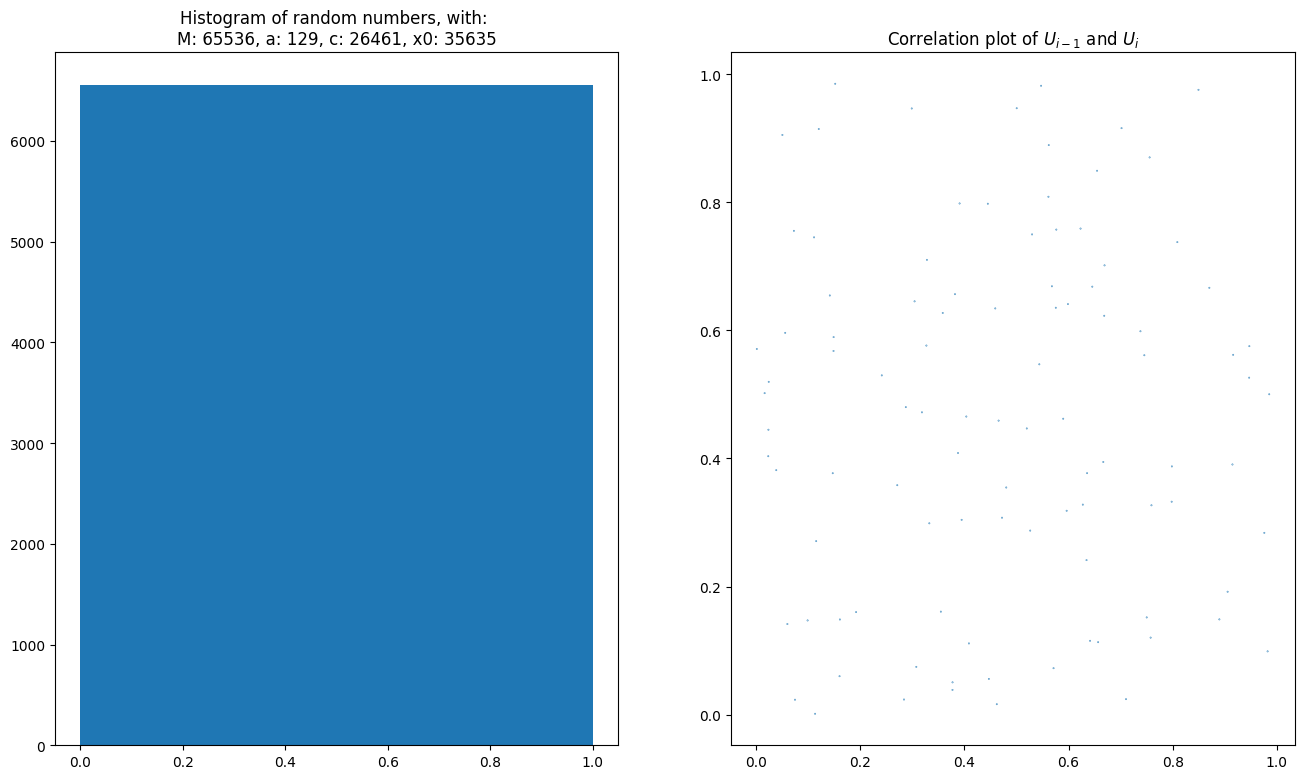

In [198]:
M = 65536
multiplier = 129
shift = 26461
x0 = 35635

chungus_test(multiplier = multiplier_hist, shift =shift_hist, modulus = M_hist, x0 = x0, plot = True, num_bins = None, num_scatter_points = None)